## Task 2: Data Characterisation

Characterise the training sets of the two tasks you’ve chosen in terms of elementary corpus statistics:





In [ ]:
import nltk
import pickle
import collections
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import sys
sys.path.insert(0, '/work/twitter-nlp')

- [x] Corpus size, vocabulary size, type/token ratio

In [ ]:
# loading data, creating a lower case corpus
from boilerplate import load_and_tokenize

hate_files = ['/work/twitter-nlp/data/tweeteval/datasets/hate/train_text.txt', "/work/twitter-nlp/data/tweeteval/datasets/hate/val_text.txt"]
emoji_files = ["/work/twitter-nlp/data/tweeteval/datasets/emoji/train_text.txt","/work/twitter-nlp/data/tweeteval/datasets/emoji/val_text.txt" ]

def load_tokenize_unpack_combine(train_file, val_file, tokenizer):
    train = load_and_tokenize(train_file, tokenizer)
    val = load_and_tokenize(val_file, tokenizer)
    unpacked_train = unpack_tokens(train)
    unpacked_val = unpack_tokens(val)
    final_df = unpacked_train + unpacked_val
    return final_df

def unpack_tokens(data):
    corpus_unpacked = []
    for line in data:
        corpus_unpacked.extend(word for word in line)
    lowercase_transition = (map(lambda x: x.lower(), corpus_unpacked))
    return list(lowercase_transition)

hatespeechCorpus = load_tokenize_unpack_combine(hate_files[0], hate_files[1], "Regex")
emojiCorpus = load_tokenize_unpack_combine(emoji_files[0], emoji_files[1], "Regex")

corpus_data = pd.DataFrame(columns=["Dataset", "Corpus size", "Vocabulary size", "Type to Token ratio"])
corpus_data["Dataset"] = ["Hatespeech", "Emoji"]
corpus_data["Corpus size"] = [len(hatespeechCorpus), len(emojiCorpus)]
corpus_data["Vocabulary size"] = [len(set(hatespeechCorpus)), len(emojiCorpus)]
corpus_data["Type to Token ratio"] = [len(set(hatespeechCorpus))/len(hatespeechCorpus),len(set(emojiCorpus))/len(emojiCorpus)]
corpus_data

,Dataset,Corpus size,Vocabulary size,Type to Token ratio
0,Hatespeech,209923,22844,0.108821
1,Emoji,570452,570452,0.121483


- [x] What are the most frequent tokens?

In [ ]:
# creating stopwords list, using text file
with open('/work/twitter-nlp/data/stopwords/stopwords.txt') as file:
    stopwords = [line.rstrip() for line in file]

#extension for stopwords - specific to our dataset
extension = ['@user', 'I', 'user', 'with', 'You', 'The', 'this', 'that', 'their', 'time', 'This', 'about', 'these', 'just', 'them', 'then', 'like', 'over', 'more', 'they', 'also', 'even','here', 'some', 'from', 'your', 'what', 'there', 'want', ' When', 'than', 'have', 'make', 'into', "you're", "don't", "will", "When", "only", "take", "&amp;", "A", "&", "@"]
stopwords.extend(extension)

In [ ]:
hatespeechCorpus_voc = collections.Counter(hatespeechCorpus)
hs_frq = pd.DataFrame(hatespeechCorpus_voc.most_common(), columns=['token', 'frequency'])

emojiCorpus_voc = collections.Counter(emojiCorpus)
emoji_frq = pd.DataFrame(emojiCorpus_voc.most_common(), columns=['token', 'frequency'])

In [ ]:
def remove_stopwords_from_df(df):
    df = df[~df.token.isin(stopwords)]
    return df

hs_wo_stopwords = remove_stopwords_from_df(hs_frq)
emoji_wo_stopwords = remove_stopwords_from_df(emoji_frq)

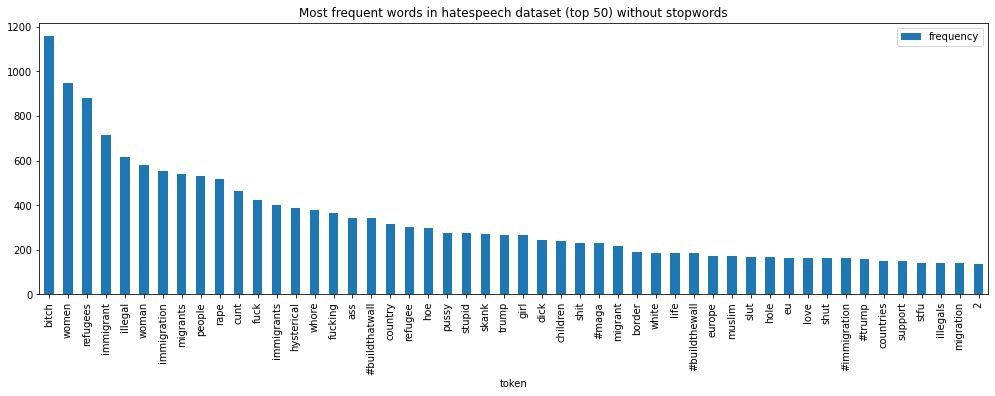

In [ ]:
hs_wo_stopwords.iloc[0:50].plot.bar(x='token',y='frequency', figsize=(17,5))
plt.title("Most frequent words in hatespeech dataset (top 50) without stopwords")
plt.xticks(rotation = 90);

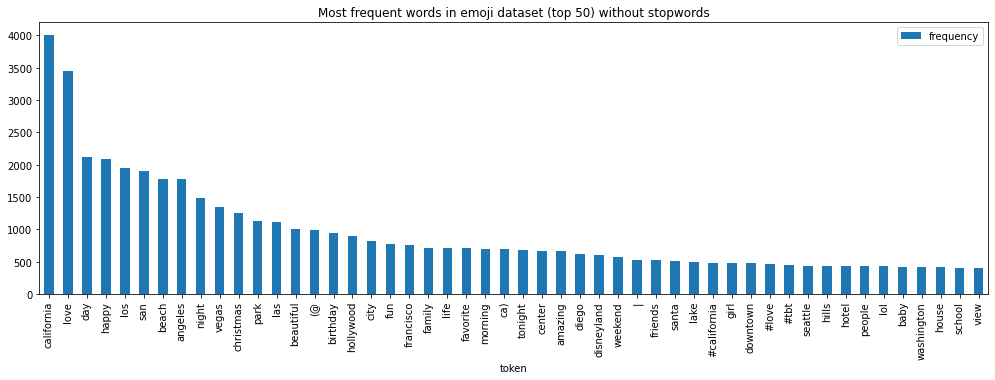

In [ ]:
emoji_wo_stopwords.iloc[0:50].plot.bar(x='token',y='frequency', figsize=(17,5))
plt.title("Most frequent words in emoji dataset (top 50) without stopwords")
plt.xticks(rotation = 90);

- [x] What types of tokens occur only once, or 2 or 3 times?

In [ ]:
# creating dicts, to make wordclouds
hs_wo_stopwords_dict = dict(zip(list(hs_wo_stopwords['token']), list(hs_wo_stopwords['frequency'])))
emoji_wo_stopwords_dict = dict(zip(list(emoji_wo_stopwords['token']), list(emoji_wo_stopwords['frequency'])))
hs_wo_stopwords_dict_lf = dict((k, v) for k, v in hs_wo_stopwords_dict.items() if v <= 3) #least frequent hate (value <= 3)
emoji_wo_stopwords_dict_lf = dict((k,v) for k, v in emoji_wo_stopwords_dict.items() if v <= 3) #least frequent emoji (value <=3)

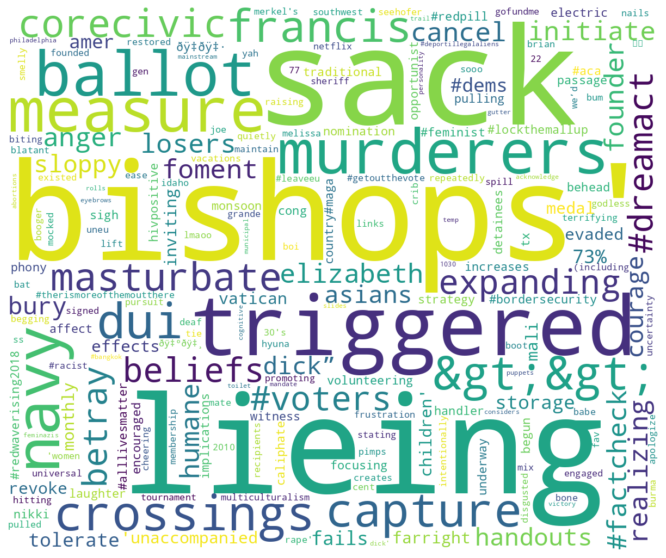

In [ ]:
def custom_wc(data):
    wordcloud = WordCloud(background_color = 'white',
                        width = 1200,
                        height = 1000)
    wordcloud.generate_from_frequencies(data)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show

# # least frequent words (count 3 and less)
custom_wc(hs_wo_stopwords_dict_lf)

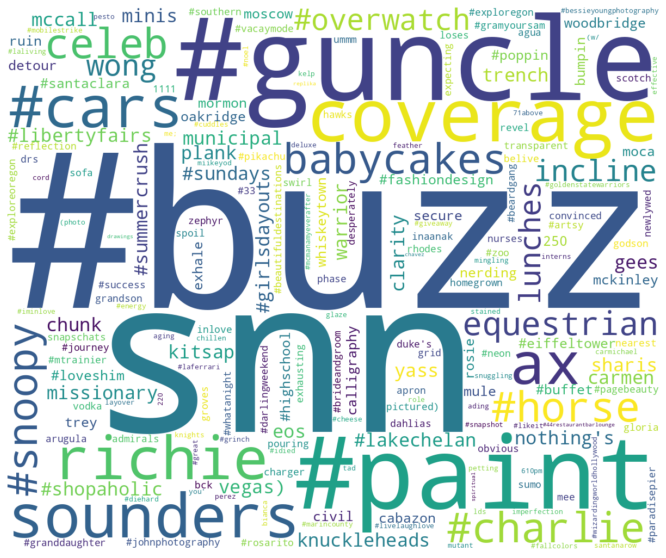

In [ ]:
custom_wc(emoji_wo_stopwords_dict_lf)

- [ ] Are there any noticeable differences between the two datasets?

The most frequent words in each dataset are very different. The content in the HateEval dataset is, as expected, much more hateful than the emoji dataset


- [x] Are the corpus statistics consistent with Zipf’s law? (plot data)

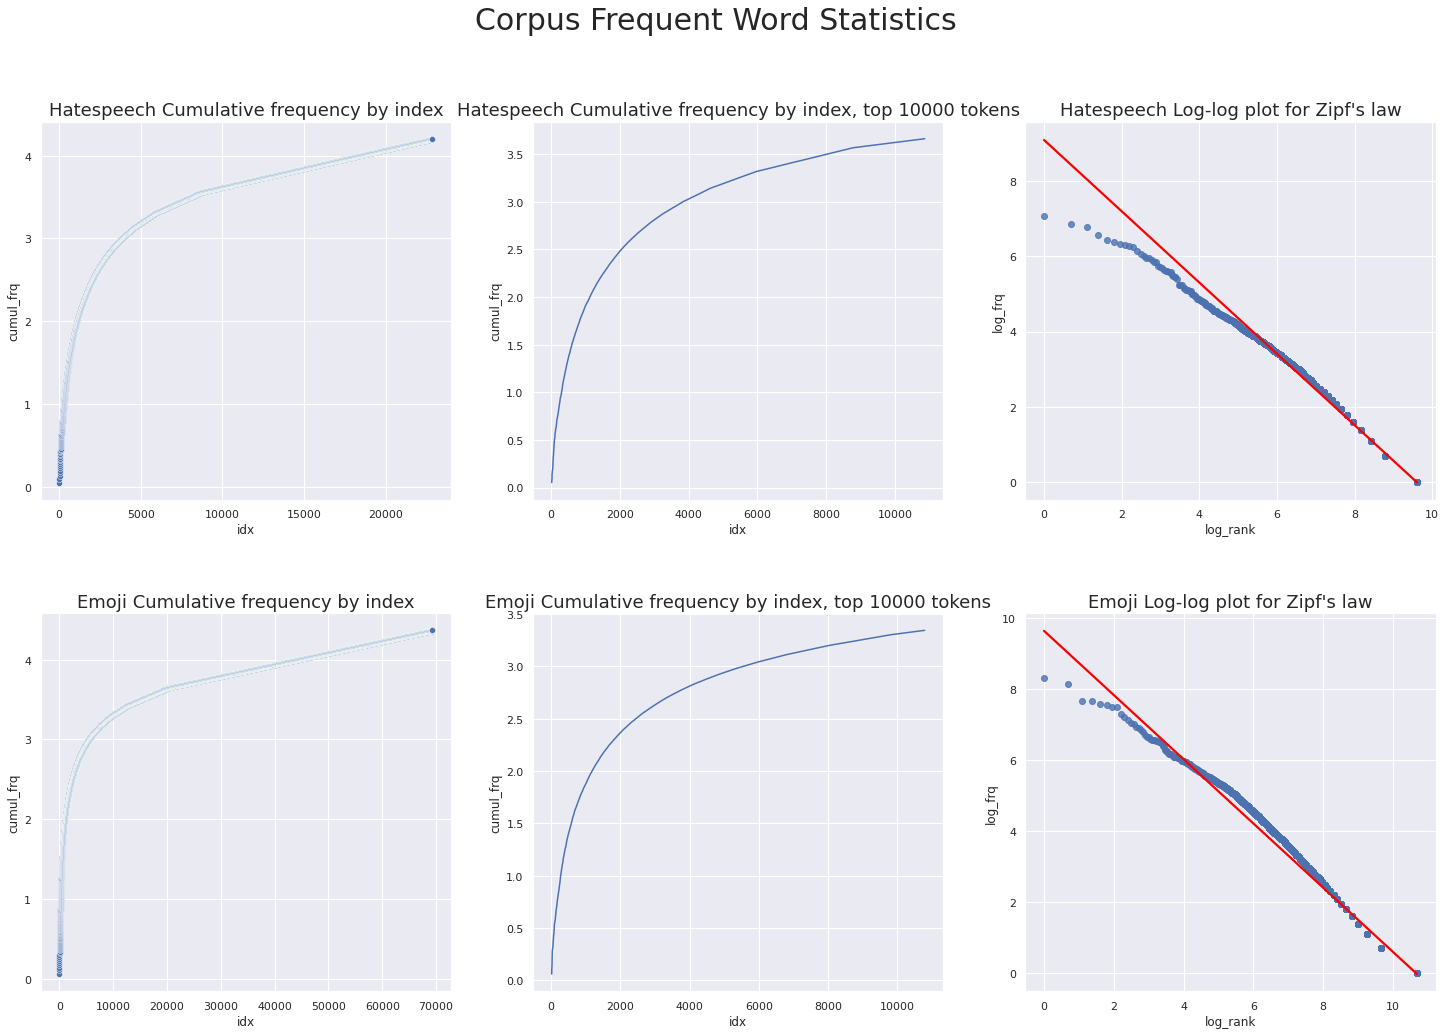

In [ ]:
# getting rid of annoying warnings:
import warnings
warnings.filterwarnings('ignore')

############### HATESPEECH Plots
hs_wo_stopwords['idx'] = hs_wo_stopwords.index + 1
hs_wo_stopwords['norm_freq'] = hs_wo_stopwords.frequency / len(hs_wo_stopwords)
hs_wo_stopwords['cumul_frq'] = hs_wo_stopwords.norm_freq.cumsum()

sns.set()
fig, axes = plt.subplots(2,3, figsize=(25,16))
fig.suptitle("Corpus Frequent Word Statistics", size=30)
sns.set_theme(style='whitegrid')
plt.subplots_adjust(hspace = 0.3)

# axes[0,0].set_xscale('log')
sns.scatterplot(ax=axes[0,0], x='idx', y='cumul_frq', data=hs_wo_stopwords).set_title("Hatespeech Cumulative frequency by index", size=18)

sns.lineplot(x='idx', y='cumul_frq', data=hs_wo_stopwords[:10000], ax=axes[0,1]).set_title("Hatespeech Cumulative frequency by index, top 10000 tokens", size=18)

hs_wo_stopwords['log_frq'] = np.log(hs_wo_stopwords.frequency)
hs_wo_stopwords['log_rank'] = np.log(hs_wo_stopwords.frequency.rank(ascending=False))
sns.regplot(x='log_rank', y='log_frq', data=hs_wo_stopwords, ax=axes[0,2], line_kws={"color": "red"}).set_title("Hatespeech Log-log plot for Zipf's law", size=18)

###################### EMOJI PLOTS
#doing zipfs law on our frq dataframe and plotting
emoji_wo_stopwords['idx'] = emoji_wo_stopwords.index + 1
emoji_wo_stopwords['norm_freq'] = emoji_wo_stopwords.frequency / len(emoji_wo_stopwords)
emoji_wo_stopwords['cumul_frq'] = emoji_wo_stopwords.norm_freq.cumsum()

# Plots
# axes[1,0].set_xscale('log')
sns.scatterplot(ax=axes[1,0], x='idx', y='cumul_frq', data=emoji_wo_stopwords).set_title("Emoji Cumulative frequency by index", size=18)

sns.lineplot(x='idx', y='cumul_frq', data=emoji_wo_stopwords[:10000], ax=axes[1,1]).set_title("Emoji Cumulative frequency by index, top 10000 tokens", size=18)

emoji_wo_stopwords['log_frq'] = np.log(emoji_wo_stopwords.frequency)
emoji_wo_stopwords['log_rank'] = np.log(emoji_wo_stopwords.frequency.rank(ascending=False))
sns.regplot(x='log_rank', y='log_frq', data=emoji_wo_stopwords, ax=axes[1,2], line_kws={"color": "red"}).set_title("Emoji Log-log plot for Zipf's law", size=18);

Based on the plots, we can say that the hatespeech corpus statistics are almost consistent with Zipfs law (the log-log plot is not quite straight). 

On the other hand, the emoji corpus statistics are far more consistent with Zipfs law. 

Be aware, the axis are not shared for each plot.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1f20fb-a6c0-4ea2-8567-a5a41eea1d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>